In [1]:
%matplotlib inline

import shutil
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchmetrics
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from data_utils import load_file

In [ ]:
def get_train_transforms() -> transforms.Compose:
    """ Повертає набір аугментацій для навчальної вибірки."""
    return transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.RandomAffine(
            degrees=0,
            translate=(0, 0.05),
            scale=(0.9, 1.1),
        ),
        transforms.Normalize(mean=[0.085], std=[0.234]),
    ])


def get_val_transforms() -> transforms.Compose:
    """Повертає набір перетворень для валідаційної та тестової вибірок."""
    return transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.085], std=[0.234]),
    ])



In [3]:
def create_dataloaders(
    train_root: Path,
    val_root: Path,
    batch_size: int = 64,
    num_workers: int = 2,
):
    """
    Створює Dataset і DataLoader для train та val.

    Параметри:
        train_root (Path): Шлях до папки із навчальними .npy файлами.
        val_root (Path): Шлях до папки з валідаційними .npy файлами.
        batch_size (int): Розмір батча.
        num_workers (int): Кількість робітників для завантаження даних.

    Повертає:
        (DataLoader, DataLoader): train_loader, val_loader.
    """
    train_dataset = torchvision.datasets.DatasetFolder(
        train_root,
        loader=load_file,
        extensions=("npy",),
        transform=get_train_transforms(),
    )

    val_dataset = torchvision.datasets.DatasetFolder(
        val_root,
        loader=load_file,
        extensions=("npy",),
        transform=get_val_transforms(),
    )

    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        persistent_workers=True,
    )

    val_loader = DataLoader(
        dataset=val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        persistent_workers=True,
    )

    return train_loader, val_loader, train_dataset, val_dataset

root_path = Path("/Users/romyna_m/Documents/pneumonia_class/Processed")

train_root = root_path / "train"
val_root   = root_path / "val"

train_loader, val_loader, train_dataset, val_dataset = create_dataloaders(
    train_root=train_root,
    val_root=val_root,
    batch_size=64,
    num_workers=2,
)


In [4]:
class FocalLoss(torch.nn.Module):
    """
    Кастомна функція втрат Focal Loss для задачі бінарної класифікації.

    Focal Loss зменшує внесок легко класифікованих прикладів
    та фокусується на складних, зменшуючи дисбаланс класів.

    Args:
        alpha (float): Вага позитивного класу (пневмонії).
            Значення в діапазоні [0, 1]. Чим більше alpha, тим більша
            важливість позитивних прикладів.
        gamma (float): Параметр фокусування. Чим більше gamma,
            тим сильніше придушуються легко класифіковані приклади.
    """

    def __init__(self, alpha: float = 0.75, gamma: float = 2.0) -> None:
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        # BCEWithLogitsLoss без редукції, щоб можна було застосувати власні ваги
        self.bce = torch.nn.BCEWithLogitsLoss(reduction="none")

    def forward(
        self,
        logits: torch.Tensor,
        targets: torch.Tensor,
    ) -> torch.Tensor:
        """
        Обчислює Focal Loss для батчу передбачень.

        Args:
            logits (torch.Tensor): Сирі логіти моделі розміру (batch_size,)
                або (batch_size, 1).
            targets (torch.Tensor): Цільові бінарні мітки (0 або 1)
                того ж розміру, що й logits.

        Returns:
            torch.Tensor: Скалярне середнє значення функції втрат
            для всього батчу.
        """
        bce_loss = self.bce(logits, targets)

        # Ймовірності класу "1" після сигмоїди
        probs = torch.sigmoid(logits)

        # pt — ймовірність правильного класу для кожного зразка
        pt = probs * targets + (1 - probs) * (1 - targets)

        # alpha_t — вага для кожного зразка (залежить від класу)
        alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)

        # Ваговий множник Focal Loss
        focal_weight = alpha_t * (1 - pt) ** self.gamma

        loss = focal_weight * bce_loss
        return loss.mean()


In [5]:
class PneumoniaModel(pl.LightningModule):
    """
    Модель для бінарної класифікації пневмонії на рентгенівських знімках.
    Побудована на основі ResNet-18 та PyTorch Lightning.
    """

    def __init__(
        self,
        alpha: float = 0.75,
        gamma: float = 2.0,
        lr: float = 1e-3,
        weight_decay: float = 1e-4,
        threshold: float = 0.45,
    ):
        """
        Ініціалізує модель PneumoniaModel.

        Параметри:
            alpha (float): Вага позитивного класу у FocalLoss.
            gamma (float): Показник фокусування складних прикладів.
            lr (float): Швидкість навчання.
            weight_decay (float): L2-регуляризація.
            threshold (float): Поріг бінарної класифікації.
        """
        super().__init__()
        self.save_hyperparameters()
        self.threshold = threshold

        base_model = resnet18(weights=ResNet18_Weights.DEFAULT)

        # Адаптація першого шару до 1-канального зображення
        old_conv = base_model.conv1
        new_conv = torch.nn.Conv2d(
            1,
            64,
            kernel_size=7,
            stride=2,
            padding=3,
            bias=False,
        )

        with torch.no_grad():
            new_conv.weight = torch.nn.Parameter(
                old_conv.weight.mean(dim=1, keepdim=True)
            )

        base_model.conv1 = new_conv
        base_model.fc = torch.nn.Linear(512, 1)
        self.model = base_model

        self.loss_fn = FocalLoss(alpha=alpha, gamma=gamma)

        self.train_acc = torchmetrics.Accuracy(
            task="binary",
            threshold=self.threshold,
        )
        self.val_acc = torchmetrics.Accuracy(
            task="binary",
            threshold=self.threshold,
        )
        self.val_rec = torchmetrics.Recall(
            task="binary",
            threshold=self.threshold,
        )
        self.val_prec = torchmetrics.Precision(
            task="binary",
            threshold=self.threshold,
        )
        self.val_f1 = torchmetrics.F1Score(
            task="binary",
            threshold=self.threshold,
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Прямий прохід через модель.

        Параметри:
            x (Tensor): Батч зображень (batch, 1, H, W).

        Повертає:
            Tensor: Логіти (batch, 1).
        """
        return self.model(x)

    def training_step(self, batch, batch_idx: int) -> torch.Tensor:
        """
        Один крок навчання моделі.

        Параметри:
            batch: Кортеж (x, y).
            batch_idx: Номер батча.

        Повертає:
            Tensor: Значення функції втрат для поточного батча.
        """
        x, y = batch
        y = y.float()

        logits = self(x)[:, 0]
        loss = self.loss_fn(logits, y)

        probs = torch.sigmoid(logits)
        self.train_acc(probs, y.int())

        self.log("Train Loss", loss, on_step=False, on_epoch=True)
        self.log("Train Acc", self.train_acc, on_epoch=True, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx: int) -> torch.Tensor:
        """
        Один крок валідації моделі.

        Параметри:
            batch: Кортеж (x, y).
            batch_idx: Номер батча.

        Повертає:
            Tensor: Значення функції втрат на цьому батчі.
        """
        x, y = batch
        y = y.float()

        logits = self(x)[:, 0]
        loss = self.loss_fn(logits, y)
        probs = torch.sigmoid(logits)

        self.val_acc(probs, y.int())
        self.val_rec(probs, y.int())
        self.val_prec(probs, y.int())
        self.val_f1(probs, y.int())

        self.log("Val Loss", loss, on_epoch=True, prog_bar=True)
        self.log("Val Acc", self.val_acc, on_epoch=True, prog_bar=True)
        self.log("Val Recall", self.val_rec, on_epoch=True, prog_bar=True)
        self.log("Val Precision", self.val_prec, on_epoch=True, prog_bar=True)
        self.log("Val F1", self.val_f1, on_epoch=True, prog_bar=True)

        return loss

    def configure_optimizers(self):
        """
        Створює оптимізатор і планувальник швидкості навчання.

        Використовує:
            - Adam як оптимізатор;
            - ReduceLROnPlateau як scheduler, що зменшує lr,
              якщо Val Loss не покращується.
        """
        optimizer = torch.optim.Adam(
            self.parameters(),
            lr=self.hparams.lr,
            weight_decay=self.hparams.weight_decay,
        )

        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode="min",
            patience=3,
            factor=0.5,
        )

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "Val Loss",
            },
        }

In [6]:
LOGGER_DIR = "logs"


def get_checkpoint_callback(
    monitor: str = "Val F1",
    save_top_k = 1,
    mode: str = "max",
    filename="best_pneumonia"
) -> ModelCheckpoint:
    """
    Створює callback ModelCheckpoint для збереження найкращої версії моделі.

    Параметри:
        monitor (str): Назва метрики, яку потрібно відстежувати під час навчання.
        save_top_k (int): Кількість найкращих моделей, які слід зберігати.
        mode (str): Режим оптимізації метрики: "max" — чим більше, тим краще;
            "min" — чим менше, тим краще.

    Повертає:
        ModelCheckpoint: Налаштований callback для використання в Trainer.
    """
    return ModelCheckpoint(
        monitor=monitor,
        save_top_k=save_top_k,
        mode=mode,
        filename="pneumonia-{epoch:02d}-{Val F1:.3f}",
    )


def get_early_stop_callback(
    monitor: str = "Val F1",
    patience: int = 10,
    mode: str = "max",
    min_delta: float = 1e-3,
) -> EarlyStopping:
    """
    Створює callback EarlyStopping для ранньої зупинки навчання.

    Параметри:
        monitor (str): Назва метрики, за якою відстежується покращення.
        patience (int): Кількість епох без покращення, після яких
            навчання буде зупинено.
        mode (str): Режим оптимізації метрики: "max" або "min".
        min_delta (float): Мінімальна зміна метрики, яка вважається
            суттєвим покращенням.

    Повертає:
        EarlyStopping: Налаштований callback для використання в Trainer.
    """
    return EarlyStopping(
        monitor=monitor,
        patience=patience,
        mode=mode,
        min_delta=min_delta,
    )


def get_tensorboard_logger(
    save_dir: str = LOGGER_DIR,
    name: str = "pneumonia",
) -> TensorBoardLogger:
    """
    Створює логер TensorBoardLogger для збереження логів навчання.

    Параметри:
        save_dir (str): Каталог, у якому будуть зберігатися логи.
        name (str): Назва експерименту (підкаталог у save_dir).

    Повертає:
        TensorBoardLogger: Налаштований логер для використання в Trainer.
    """
    return TensorBoardLogger(
        save_dir=save_dir,
        name=name,
    )


# Ініціалізація
checkpoint_callback = get_checkpoint_callback()
early_stop_callback = get_early_stop_callback()
logger = get_tensorboard_logger()


In [7]:
def create_trainer(logger, checkpoint_callback, early_stop_callback):
    """
    Створює та повертає об’єкт Trainer для навчання моделі.

    Параметри:
        logger (LightningLoggerBase):
            Логер для збереження метрик, графіків та інших артефактів навчання.
        checkpoint_callback (ModelCheckpoint):
            Callback, що зберігає найкращі моделі.
        early_stop_callback (EarlyStopping):
            Callback, що зупиняє навчання за відсутності покращення метрики.

    Повертає:
        pl.Trainer: Налаштований Trainer для роботи з однією GPU або CPU.
    """
    return pl.Trainer(
        accelerator="auto",
        devices=1,
        max_epochs=40,
        logger=logger,
        callbacks=[checkpoint_callback, early_stop_callback],
    )

trainer = create_trainer(logger, checkpoint_callback, early_stop_callback)

model = PneumoniaModel()

trainer.fit(model, train_loader, val_loader)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NameError: name 'FocalLoss' is not defined

In [7]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ckpt_path = "/Users/romyna_m/Documents/pneumonia_class/Pneumonia_Classification/pneumonia_best.ckpt"  # або інший шлях

model = PneumoniaModel.load_from_checkpoint(ckpt_path)
model.to(device)
model.eval()


PneumoniaModel(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [8]:
def load_best_model(
    checkpoint_callback: ModelCheckpoint,
    output_path: str = "pneumonia_best.ckpt",
) -> PneumoniaModel:
    """
    Завантажує найкращий чекпойнт моделі, збережений під час тренування,
    копіює його у вказаний файл та повертає готову до інференсу модель.

    Параметри:
        checkpoint_callback (ModelCheckpoint):
            Callback, який містить шлях до найкращого чекпойнта.
        output_path (str):
            Шлях/імʼя файлу, куди буде скопійовано чекпойнт.

    Повертає:
        PneumoniaModel: Модель, відновлена з найкращого чекпойнта.
    """
    best_ckpt = checkpoint_callback.best_model_path
    print(f"Best checkpoint: {best_ckpt}")

    shutil.copy(best_ckpt, output_path)

    model = PneumoniaModel.load_from_checkpoint(output_path)
    model.eval()

    return model

In [9]:
def collect_predictions(model, loader, device=None):
    """
    Проганяє модель по loader і повертає тензори preds та labels.
    """
    if device is None:
        if torch.cuda.is_available():
            device = torch.device("cuda")
        elif torch.backends.mps.is_available():
            device = torch.device("mps")
        else:
            device = torch.device("cpu")

    model.to(device)
    model.eval()

    preds = []
    labels = []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            logits = model(x)[:, 0]
            prob = torch.sigmoid(logits)

            preds.append(prob.cpu())
            labels.append(y.cpu())

    preds = torch.cat(preds)
    labels = torch.cat(labels).int()

    return preds, labels

preds, labels = collect_predictions(model, val_loader)


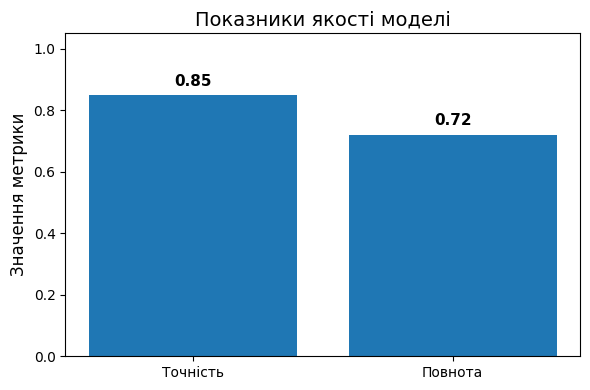

In [10]:
def plot_binary_metrics(preds: torch.Tensor, labels: torch.Tensor):
    """
    Обчислює та візуалізує основні метрики для бінарної класифікації.
    """
    acc = torchmetrics.Accuracy(task="binary")(preds, labels).item()
    rec = torchmetrics.Recall(task="binary")(preds, labels).item()

    metrics_names = ["Точність", "Повнота"]
    metrics_values = [acc, rec]

    plt.figure(figsize=(6, 4))
    bars = plt.bar(metrics_names, metrics_values)

    for bar, value in zip(bars, metrics_values):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            value + 0.02,
            f"{value:.2f}",
            ha="center",
            va="bottom",
            fontsize=11,
            fontweight="bold",
        )

    plt.ylim(0, 1.05)
    plt.ylabel("Значення метрики", fontsize=12)
    plt.title("Показники якості моделі", fontsize=14)
    plt.tight_layout()
    plt.show()
    
plot_binary_metrics(preds, labels)


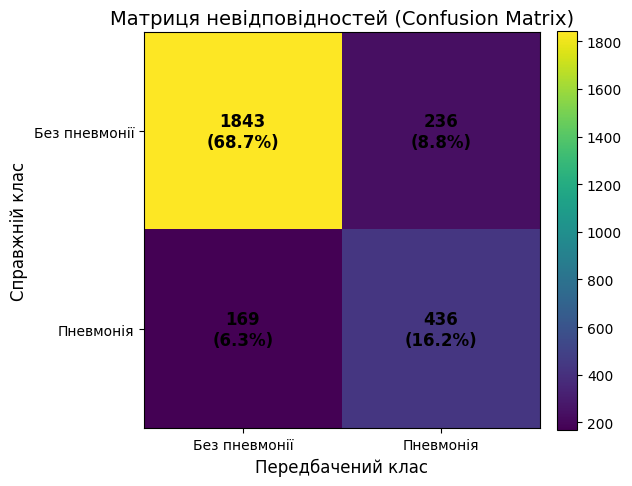

In [11]:
def plot_confusion_matrix(preds: torch.Tensor, labels: torch.Tensor):
    """
    Будує матрицю невідповідностей для задачі бінарної класифікації
    та візуалізує її у вигляді теплової карти.
    """
    cm = torchmetrics.ConfusionMatrix(task="binary")(preds, labels).numpy()

    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm, interpolation="nearest")

    ax.set_title("Матриця невідповідностей (Confusion Matrix)", fontsize=14)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    ax.set_xlabel("Передбачений клас", fontsize=12)
    ax.set_ylabel("Справжній клас", fontsize=12)
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["Без пневмонії", "Пневмонія"])
    ax.set_yticklabels(["Без пневмонії", "Пневмонія"])

    total = cm.sum()
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            count = cm[i, j]
            perc = count / total if total > 0 else 0

            ax.text(
                j,
                i,
                f"{count}\n({perc:.1%})",
                ha="center",
                va="center",
                fontsize=12,
                fontweight="bold",
            )

    plt.tight_layout()
    plt.show()

plot_confusion_matrix(preds, labels)

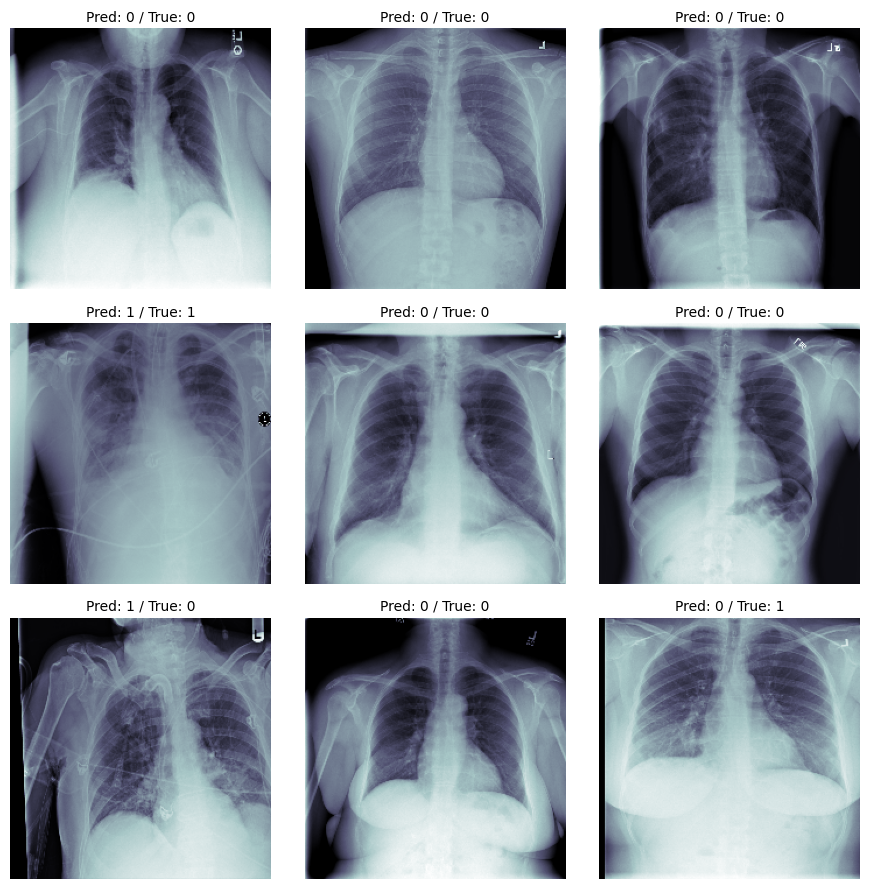

In [12]:
def plot_random_predictions_grid(
    preds: torch.Tensor,
    labels: torch.Tensor,
    dataset,
    grid_size: int = 3,
    threshold: float = 0.5,
):
    """
    Виводить сітку випадкових зображень із валідаційного набору разом
    із їхніми передбаченнями та справжніми мітками.
    """
    fig, ax = plt.subplots(
        grid_size,
        grid_size,
        figsize=(3 * grid_size, 3 * grid_size),
    )

    total = len(preds)

    for i in range(grid_size):
        for j in range(grid_size):
            idx = np.random.randint(0, total)
            img, _ = dataset[idx]

            ax[i][j].imshow(img[0], cmap="bone")
            ax[i][j].set_title(
                f"Pred: {int(preds[idx] > threshold)} / True: {int(labels[idx])}",
                fontsize=10,
            )
            ax[i][j].axis("off")

    plt.tight_layout()
    plt.show()

plot_random_predictions_grid(preds, labels, val_dataset, grid_size=3)